**Market-basket analysis**

The task is to implement a system finding frequent itemsets (aka market-basket analysis), analyzing the LinkedIn Jobs & Skills dataset. The detector must consider as baskets the strings contained in the job_skills column of the  job_skills.csv file, using skills as items.


# Install and Configure Requirements

**Install Packages**

In [ ]:
# Install necessary packages
!pip install -q pyspark findspark kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


**install java development kit for spark**

In [ ]:
# Install java development kit for spark
!apt-get install openjdk-11-jdk-headless -qq > /dev/null


In [ ]:
#check java version
!java -version

openjdk version "11.0.23" 2024-04-16
OpenJDK Runtime Environment (build 11.0.23+9-post-Ubuntu-1ubuntu122.04.1)
OpenJDK 64-Bit Server VM (build 11.0.23+9-post-Ubuntu-1ubuntu122.04.1, mixed mode, sharing)


In [ ]:
!update-alternatives --list java

/usr/lib/jvm/java-11-openjdk-amd64/bin/java


**Import Libraries**

In [ ]:
import os
import findspark
from google.colab import files
from pyspark.sql import SparkSession
from google.colab import drive
from pyspark.ml.fpm import FPGrowth
import pandas as pd
import pyspark.sql.functions as f
from pyspark.sql.functions import col, split, array_distinct
from pyspark.ml.feature import StopWordsRemover
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns


**set the JAVA and SPARK path**

In [ ]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/drive/MyDrive/Kaggle_API_Token/spark-3.5.1-bin-hadoop3"

**Mount the Google Drive**

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!chmod -R 755 /content/drive/MyDrive/Kaggle_API_Token/spark-3.5.1-bin-hadoop3

**Configure Kaggle API Key and Download Dataset**

In [ ]:
# Set Kaggle Config Directory
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle_API_Token"

In [ ]:
# Change Directory
%cd /content/drive/My Drive/Kaggle_API_Token/dataset

In [ ]:
# Download dataset from kaggle
!kaggle datasets download asaniczka/1-3m-linkedin-jobs-and-skills-2024

In [ ]:
# Unzip
!unzip -q /content/drive/MyDrive/Kaggle_API_Token/dataset/1-3m-linkedin-jobs-and-skills-2024.zip

In [ ]:
# Remove
!rm /content/drive/MyDrive/Kaggle_API_Token/dataset/1-3m-linkedin-jobs-and-skills-2024.zip

**Start a SparkSession**

In [ ]:
# Start a SparkSession
findspark.init()
spark = SparkSession.builder.appName("frequent-itemsets").getOrCreate()

# preprocessing

In [ ]:
# Load job skills data
df = spark.read.csv('/content/drive/MyDrive/Kaggle_API_Token/dataset/job_skills.csv', inferSchema=True, header=True)

In [ ]:
#check dimension
print((df.count(), len(df.columns)))

(1296381, 2)


In [ ]:
#Check for the schema
df.printSchema()

root
 |-- job_link: string (nullable = true)
 |-- job_skills: string (nullable = true)



In [ ]:
df.show(5, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|job_link                                                                                                                       |job_skills                                              

In [ ]:
# Check for duplicates rows
print(f"Count of duplicate rows: {df.count() - df.distinct().count()}")

Count of duplicate rows: 0


In [ ]:
# Remove rows with null job_skills and split the strings into lists
df_clean = df.filter(col("job_skills").isNotNull()).withColumn("skills", split(col("job_skills"), ",\s*"))

In [ ]:
df_clean.printSchema()

root
 |-- job_link: string (nullable = true)
 |-- job_skills: string (nullable = true)
 |-- skills: array (nullable = true)
 |    |-- element: string (containsNull = false)



In [ ]:
df_clean.show(5, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#check dimension
print((df_clean.count(), len(df_clean.columns)))

(1294374, 3)


# Do the project on sampled data

In [ ]:
# Sample a fraction of the data
sampled_df = df_clean.sample(fraction=0.05, seed=0)

In [ ]:
sampled_df.printSchema()

root
 |-- job_link: string (nullable = true)
 |-- job_skills: string (nullable = true)
 |-- skills: array (nullable = true)
 |    |-- element: string (containsNull = false)



In [ ]:
# Define and remove stop words
stop_words_remover = StopWordsRemover(inputCol="skills", outputCol="transactions")
sampled_df = stop_words_remover.transform(sampled_df)

In [ ]:
transactions_df = df_clean.select("transactions").withColumn("transactions", array_distinct("transactions"))
transactions_df = transactions_df.repartition(10)

In [ ]:
# Apply the FP-Growth algorithm
fp_growth = FPGrowth(itemsCol="transactions", minSupport=0.01, minConfidence=0.5)
model = fp_growth.fit(transactions_df)

In [ ]:
# Get frequent itemsets and sort by frequency in descending order
frequent_itemsets = model.freqItemsets.orderBy(f.col("freq").desc())
association_rules = model.associationRules

In [ ]:
frequent_itemsets.show(truncate=False)

+---------------------------------+-----+
|items                            |freq |
+---------------------------------+-----+
|[Communication]                  |18165|
|[Teamwork]                       |11315|
|[Leadership]                     |8949 |
|[Customer service]               |8269 |
|[Teamwork, Communication]        |6974 |
|[Communication skills]           |5826 |
|[Leadership, Communication]      |5697 |
|[Customer Service]               |5448 |
|[Problem Solving]                |5002 |
|[Sales]                          |4651 |
|[Problemsolving]                 |4481 |
|[Nursing]                        |4352 |
|[Collaboration]                  |4149 |
|[Training]                       |4087 |
|[Customer service, Communication]|4016 |
|[Project Management]             |3953 |
|[Attention to detail]            |3776 |
|[Communication Skills]           |3767 |
|[Microsoft Office Suite]         |3578 |
|[Time management]                |3553 |
+---------------------------------

In [ ]:
association_rules.show(truncate=False)

+--------------------------------------+------------------+------------------+------------------+--------------------+
|antecedent                            |consequent        |confidence        |lift              |support             |
+--------------------------------------+------------------+------------------+------------------+--------------------+
|[Time management, Attention to detail]|[Teamwork]        |0.598014888337469 |3.410138280176625 |0.01120530663484339 |
|[Time management, Attention to detail]|[Communication]   |0.6153846153846154|2.1858773211374367|0.011530771972784898|
|[Problem solving, Communication]      |[Customer service]|0.5062362435803375|3.9501609801105473|0.010693861103792446|
|[Collaboration]                       |[Communication]   |0.584237165582068 |2.075240001918622 |0.03756799900810564 |
|[Collaboration, Leadership]           |[Communication]   |0.7486818980667839|2.6593560203117583|0.013204593710769803|
|[Time management, Customer service]   |[Teamwor

# Experiment with different support and confidence values

In [ ]:
best_support = 0
best_confidence = 0
best_num_rules = 0

for support in [0.001, 0.005, 0.01]:
    for confidence in [0.2, 0.4, 0.6]:
        fp_growth = FPGrowth(itemsCol="transactions", minSupport=support, minConfidence=confidence)
        model = fp_growth.fit(transactions_df)
        rules = model.associationRules.count()
        print(f"Support: {support}, Confidence: {confidence}, Number of Rules: {rules}")

Support: 0.001, Confidence: 0.2, Number of Rules: 160891
Support: 0.001, Confidence: 0.4, Number of Rules: 146906
Support: 0.001, Confidence: 0.6, Number of Rules: 132452
Support: 0.005, Confidence: 0.2, Number of Rules: 1572
Support: 0.005, Confidence: 0.4, Number of Rules: 979
Support: 0.005, Confidence: 0.6, Number of Rules: 485
Support: 0.01, Confidence: 0.2, Number of Rules: 376
Support: 0.01, Confidence: 0.4, Number of Rules: 222
Support: 0.01, Confidence: 0.6, Number of Rules: 100


# Do the project on full data

In [ ]:
# Define and remove stop words
stop_words_remover = StopWordsRemover(inputCol="skills", outputCol="transactions")
df_clean = stop_words_remover.transform(df_clean)

In [ ]:
transactions_df = df_clean.select("transactions").withColumn("transactions", array_distinct("transactions"))
transactions_df = transactions_df.repartition(10)

In [ ]:
# Apply the FP-Growth algorithm
fp_growth = FPGrowth(itemsCol="transactions", minSupport=0.005, minConfidence=0.4)
model = fp_growth.fit(transactions_df)

In [ ]:
# Get frequent itemsets and sort by frequency in descending order
frequent_itemsets = model.freqItemsets.orderBy(f.col("freq").desc())
association_rules = model.associationRules

In [ ]:
print(f"Number of Rules: {model.associationRules.count()}")

Number of Rules: 984


In [ ]:
frequent_itemsets.show(truncate=False)

+---------------------------------+------+
|items                            |freq  |
+---------------------------------+------+
|[Communication]                  |364027|
|[Teamwork]                       |224629|
|[Leadership]                     |182796|
|[Customer service]               |165403|
|[Teamwork, Communication]        |138347|
|[Leadership, Communication]      |116574|
|[Communication skills]           |115642|
|[Customer Service]               |109616|
|[Problem Solving]                |99866 |
|[Sales]                          |92324 |
|[Problemsolving]                 |90800 |
|[Nursing]                        |87186 |
|[Collaboration]                  |85885 |
|[Training]                       |82204 |
|[Customer service, Communication]|81201 |
|[Project Management]             |80122 |
|[Communication Skills]           |78359 |
|[Attention to detail]            |74758 |
|[Microsoft Office Suite]         |72717 |
|[Time management]                |72044 |
+----------

In [ ]:
association_rules.show(truncate=False)

+----------------------------------------------------------+---------------------+-------------------+------------------+---------------------+
|antecedent                                                |consequent           |confidence         |lift              |support              |
+----------------------------------------------------------+---------------------+-------------------+------------------+---------------------+
|[Time Management, Leadership, Communication]              |[Teamwork]           |0.5580324691058881 |3.2155363695981585|0.007116953832508996 |
|[Time Management, Leadership, Communication]              |[Customer Service]   |0.4614732251029804 |5.449194864522014 |0.005885470505433515 |
|[Time Management, Leadership, Communication]              |[Problem Solving]    |0.6312696874242791 |8.181954522961908 |0.008050996079958343 |
|[Planning, Leadership]                                    |[Communication]      |0.7403269754768392 |2.632387126657798 |0.0062972525715

In [ ]:
association_rules.describe("confidence").show()

+-------+-------------------+
|summary|         confidence|
+-------+-------------------+
|  count|                984|
|   mean|  0.613020902091151|
| stddev|0.14453877254360148|
|    min| 0.4006851571249753|
|    max| 0.9915927136851939|
+-------+-------------------+



In [ ]:
association_rules.describe("support").show()

+-------+--------------------+
|summary|             support|
+-------+--------------------+
|  count|                 984|
|   mean|0.009203508816095815|
| stddev|0.007128414414189697|
|    min|0.005000873008883059|
|    max| 0.10688332738451174|
+-------+--------------------+



# visualization

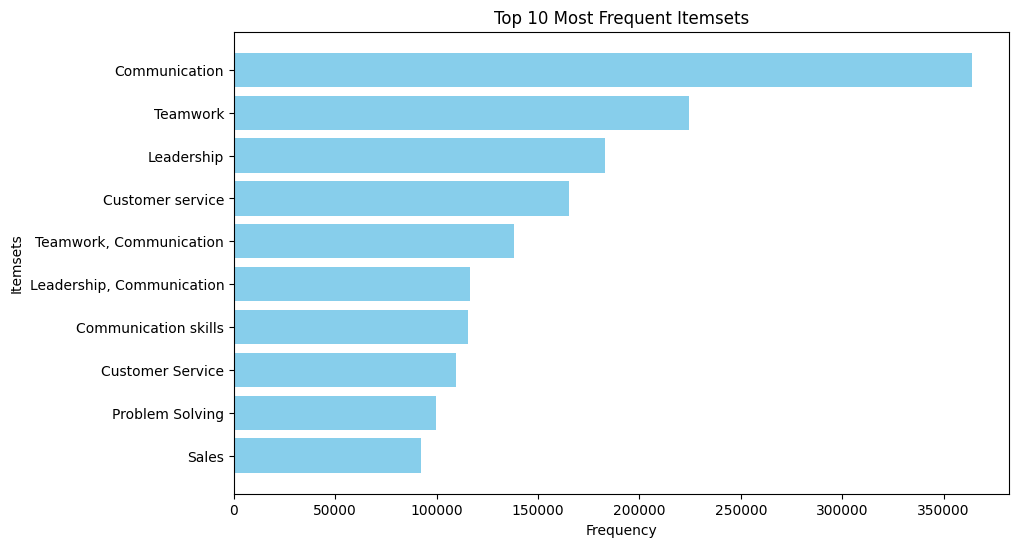

In [ ]:
# Convert Spark DataFrame to Pandas DataFrame for visualization
pandas_df = model.freqItemsets.orderBy("freq", ascending=False).limit(10).toPandas()

# Convert list of items in each itemset into a string to use as a label
pandas_df['items'] = pandas_df['items'].apply(lambda x: ', '.join(x))

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(pandas_df['items'], pandas_df['freq'], color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Itemsets')
plt.title('Top 10 Most Frequent Itemsets')
plt.gca().invert_yaxis()
plt.show()



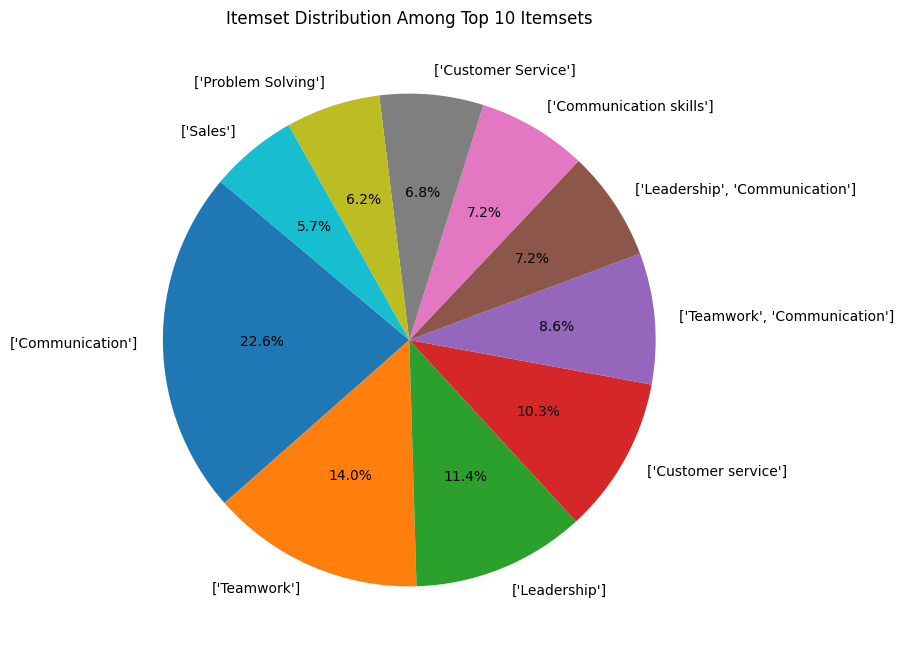

In [ ]:
# Generate the pie chart for the top 5 most frequent itemsets
pie_data = model.freqItemsets.orderBy("freq", ascending=False).limit(10).toPandas()

plt.figure(figsize=(8, 8))
plt.pie(pie_data['freq'], labels=pie_data['items'], autopct='%1.1f%%', startangle=140)
plt.title('Itemset Distribution Among Top 10 Itemsets')
plt.show()


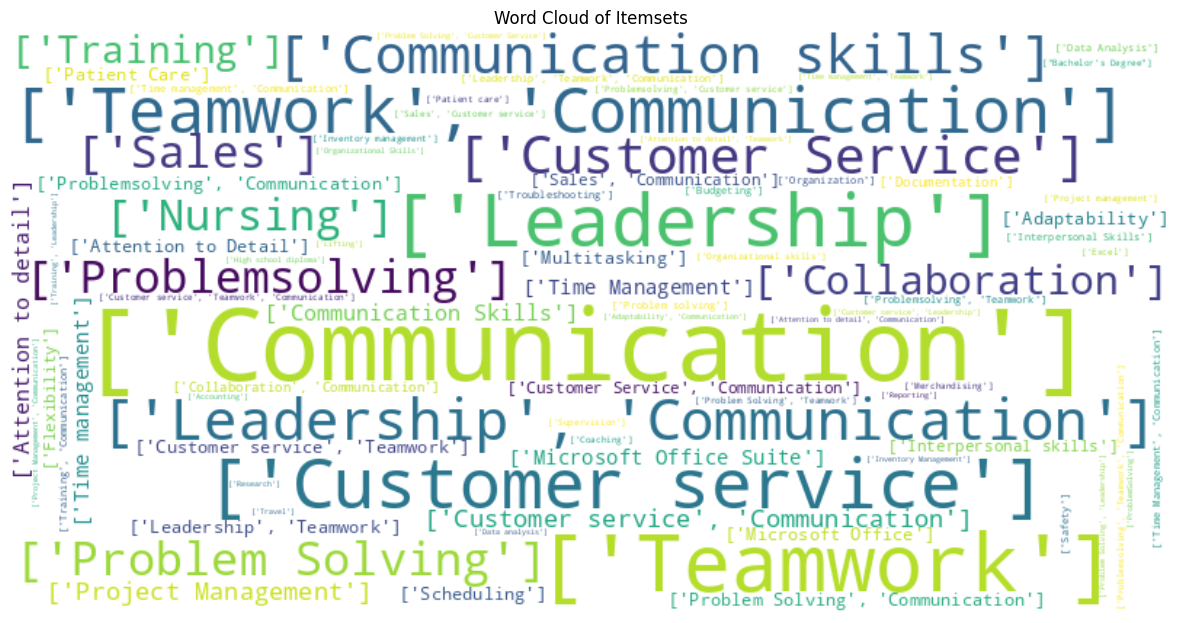

In [ ]:
# Generate a word cloud for the itemsets
item_freq_dict = {str(items): freq for items, freq in model.freqItemsets.rdd.map(lambda row: (row['items'], row['freq'])).collect()}
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(item_freq_dict)

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Word Cloud of Itemsets')
plt.show()



# Association visualization

In [ ]:
rules_pd = association_rules.toPandas()

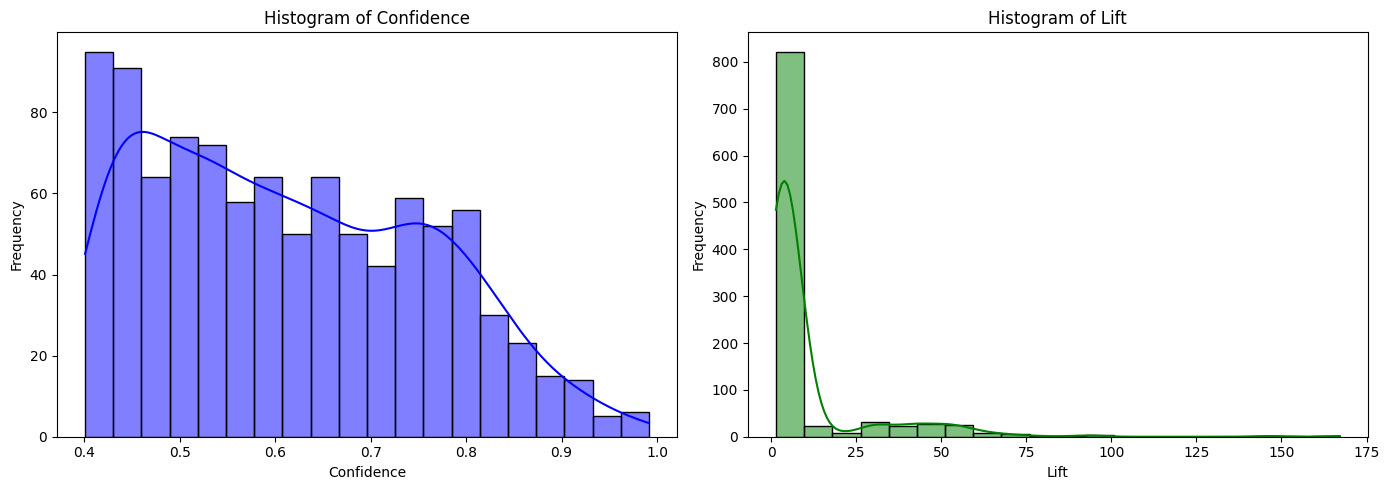

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(rules_pd['confidence'], bins=20, kde=True, ax=ax[0], color='blue')
ax[0].set_title('Histogram of Confidence')
ax[0].set_xlabel('Confidence')
ax[0].set_ylabel('Frequency')

sns.histplot(rules_pd['lift'], bins=20, kde=True, ax=ax[1], color='green')
ax[1].set_title('Histogram of Lift')
ax[1].set_xlabel('Lift')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


# Final experiment with minSupprt = 0.01 and minConfodence = 0.6

In [ ]:
# Apply the FP-Growth algorithm
fp_growth = FPGrowth(itemsCol="transactions", minSupport=0.01, minConfidence=0.6)
model = fp_growth.fit(transactions_df)

In [ ]:
# Get frequent itemsets and sort by frequency in descending order
frequent_itemsets = model.freqItemsets.orderBy(f.col("freq").desc())
association_rules = model.associationRules

In [ ]:
print(f"Number of Rules: {model.associationRules.count()}")

Number of Rules: 106


In [ ]:
frequent_itemsets.show(truncate=False)

+---------------------------------+------+
|items                            |freq  |
+---------------------------------+------+
|[Communication]                  |364027|
|[Teamwork]                       |224629|
|[Leadership]                     |182796|
|[Customer service]               |165403|
|[Teamwork, Communication]        |138347|
|[Leadership, Communication]      |116574|
|[Communication skills]           |115642|
|[Customer Service]               |109616|
|[Problem Solving]                |99866 |
|[Sales]                          |92324 |
|[Problemsolving]                 |90800 |
|[Nursing]                        |87186 |
|[Collaboration]                  |85885 |
|[Training]                       |82204 |
|[Customer service, Communication]|81201 |
|[Project Management]             |80122 |
|[Communication Skills]           |78359 |
|[Attention to detail]            |74758 |
|[Microsoft Office Suite]         |72717 |
|[Time management]                |72044 |
+----------

In [ ]:
association_rules.show(truncate=False)

+----------------------------------------------------+------------------+------------------+------------------+--------------------+
|antecedent                                          |consequent        |confidence        |lift              |support             |
+----------------------------------------------------+------------------+------------------+------------------+--------------------+
|[Time management, Attention to detail]              |[Communication]   |0.6237104961519567|2.2177328872479043|0.01177094101086703 |
|[Time management, Customer service]                 |[Communication]   |0.6816374195177377|2.423704157248919 |0.01668528570567703 |
|[Collaboration, Leadership]                         |[Communication]   |0.7640491254186825|2.7167361834827686|0.014274854099356136|
|[Project Management, Problem Solving]               |[Communication]   |0.6699751861042184|2.382236651507887 |0.01001256205702525 |
|[Attention to Detail, Problem Solving]              |[Communication]

In [ ]:
association_rules.describe("confidence").show()

+-------+-------------------+
|summary|         confidence|
+-------+-------------------+
|  count|                106|
|   mean| 0.7194596300438914|
| stddev|0.08198292881847866|
|    min|   0.60115755847903|
|    max| 0.9589651544222318|
+-------+-------------------+



In [ ]:
association_rules.describe("support").show()

+-------+--------------------+
|summary|             support|
+-------+--------------------+
|  count|                 106|
|   mean|0.017112460948923484|
| stddev|0.013479809107574833|
|    min|0.010011016908559659|
|    max| 0.10688332738451174|
+-------+--------------------+



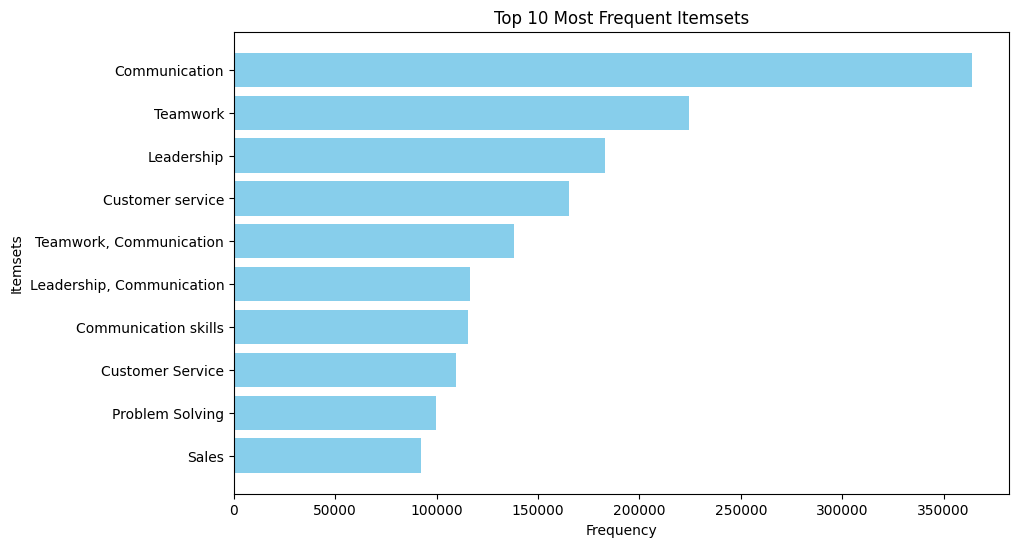

In [ ]:
# Convert Spark DataFrame to Pandas DataFrame for visualization
pandas_df = model.freqItemsets.orderBy("freq", ascending=False).limit(10).toPandas()

# Convert list of items in each itemset into a string to use as a label
pandas_df['items'] = pandas_df['items'].apply(lambda x: ', '.join(x))

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(pandas_df['items'], pandas_df['freq'], color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Itemsets')
plt.title('Top 10 Most Frequent Itemsets')
plt.gca().invert_yaxis()
plt.show()

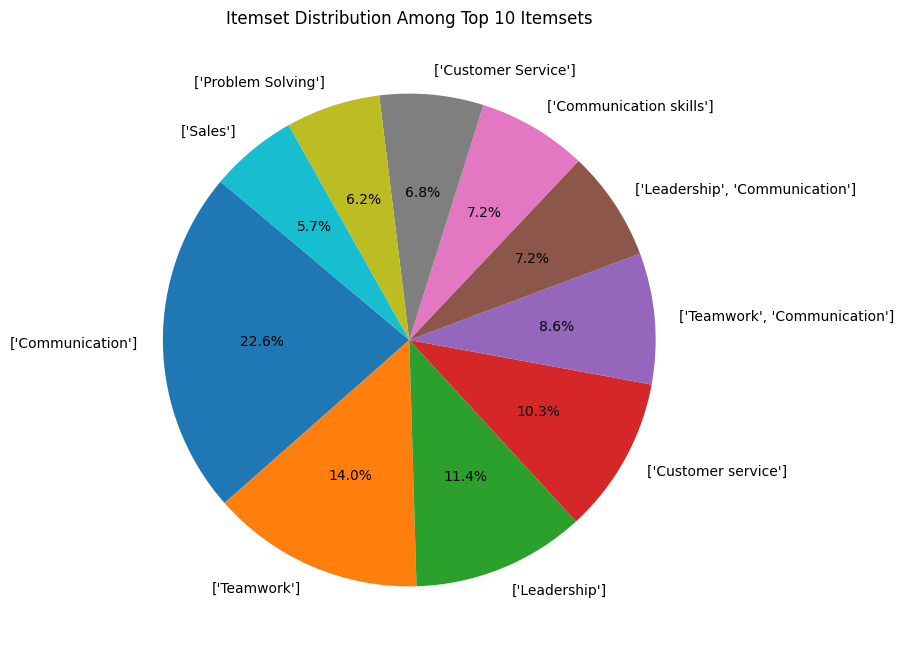

In [ ]:
# Generate the pie chart for the top 5 most frequent itemsets
pie_data = model.freqItemsets.orderBy("freq", ascending=False).limit(10).toPandas()

plt.figure(figsize=(8, 8))
plt.pie(pie_data['freq'], labels=pie_data['items'], autopct='%1.1f%%', startangle=140)
plt.title('Itemset Distribution Among Top 10 Itemsets')
plt.show()


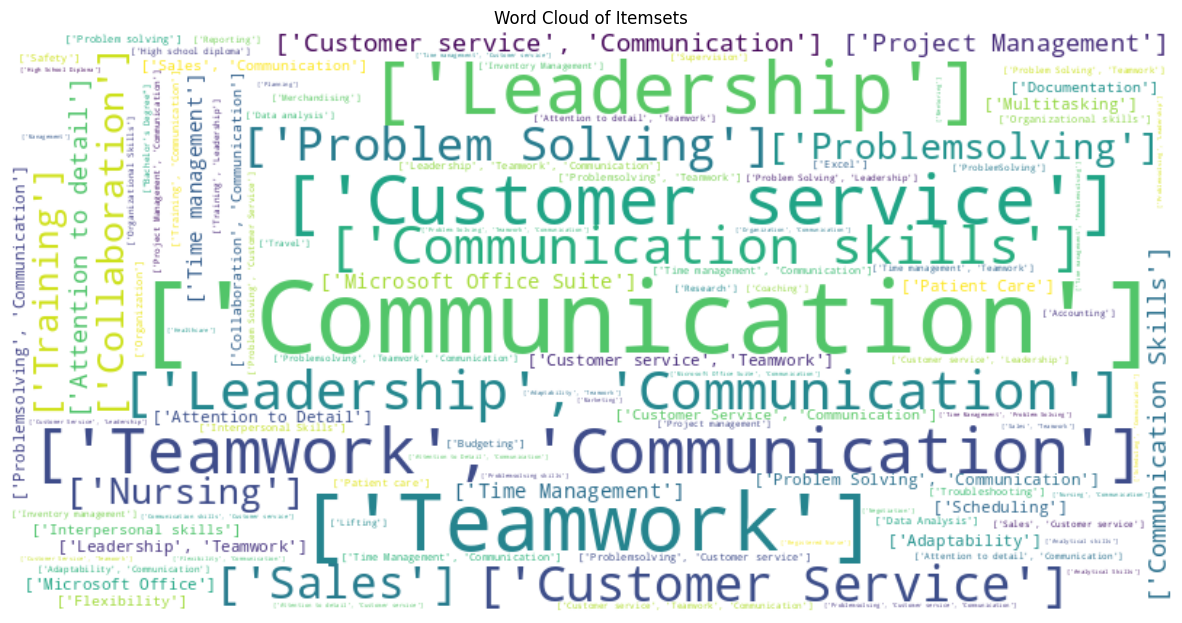

In [ ]:
# Generate a word cloud for the itemsets
item_freq_dict = {str(items): freq for items, freq in model.freqItemsets.rdd.map(lambda row: (row['items'], row['freq'])).collect()}
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(item_freq_dict)

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Word Cloud of Itemsets')
plt.show()



In [ ]:
rules_pd = association_rules.toPandas()

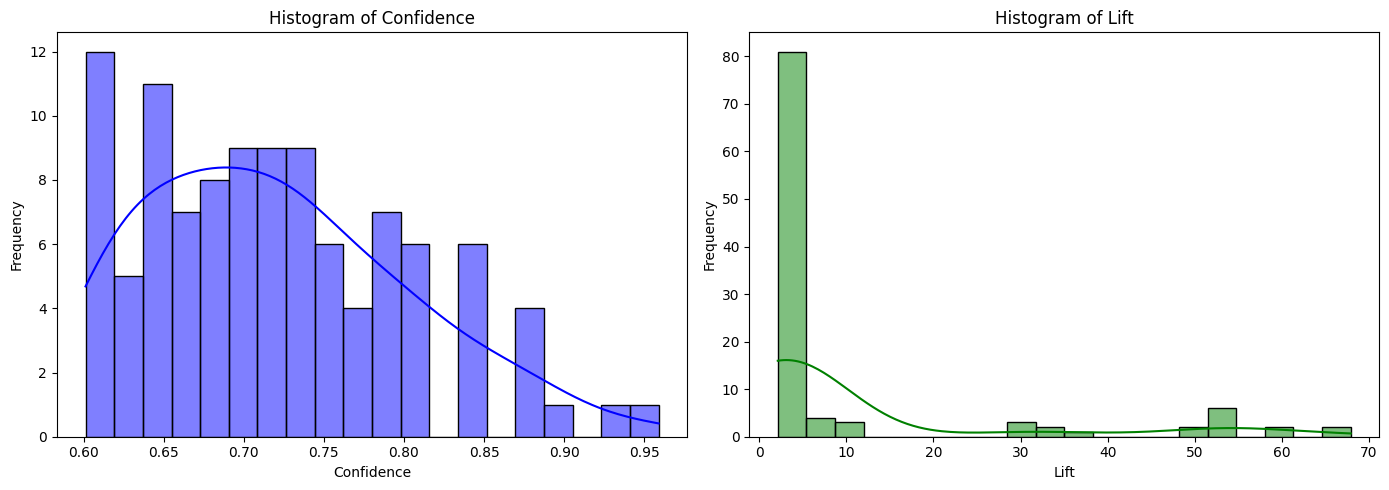

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(rules_pd['confidence'], bins=20, kde=True, ax=ax[0], color='blue')
ax[0].set_title('Histogram of Confidence')
ax[0].set_xlabel('Confidence')
ax[0].set_ylabel('Frequency')

sns.histplot(rules_pd['lift'], bins=20, kde=True, ax=ax[1], color='green')
ax[1].set_title('Histogram of Lift')
ax[1].set_xlabel('Lift')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()
